In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split


## Mix Integer States

In [2]:
def all_same_integers(lst):
    if not lst:  
        return False
    return all(isinstance(x, int) and x == lst[0] for x in lst)

def remove_all_mix_oxidation_state(data):
    '''
    Remove all entries with non-integer oxidation states.
    '''
    total = 0
    mix = 0
    mixed = []
    for element, value in data.items():
        for mpid, spectrum in value.items():
            oxidation_state = spectrum['oxidation_state']
            if not all_same_integers(oxidation_state): 
                mixed.append((element, mpid))  
                mix += 1
            total += 1

    for i in mixed:
        if i[0] in data and i[1] in data[i[0]]:
            del data[i[0]][i[1]]
    print(f"Total: {total}, Mixed: {mix}")

    return data


In [3]:
def expand_spectra(intensity: np.array, energy: np.array, energy_grid: np.array) -> np.array:
    interval = energy[1] - energy[0]
    while energy[0] > energy_grid[0]:
        energy = np.insert(energy, 0, energy[0] - interval)
        intensity = np.insert(intensity, 0, 0)
    while energy[-1] < energy_grid[-1]:
        energy = np.insert(energy, len(energy), energy[-1] + interval)
        intensity = np.insert(intensity, len(intensity), 0)
    return intensity, energy

# smoothing the spectra
def savgol_smooth(intensity: np.array, energy: np.array, energy_grid: np.array, energy_window_length, polyorder: int = 3) -> np.array:
    intensity, energy = expand_spectra(intensity, energy, energy_grid)
    interval = energy[1] - energy[0]
    window_length = int(energy_window_length / interval)
    if window_length % 2 == 0:
        window_length += 1
    if window_length < polyorder + 2:
        window_length = polyorder + 2
    smooth_intensity = savgol_filter(intensity, window_length, polyorder)
    interp_func = interp1d(energy, smooth_intensity, kind='cubic')
    intensity_on_new_grid = interp_func(energy_grid)
    return intensity_on_new_grid


In [4]:
def get_integer_oxidation_state(data):
    '''
    Get the integer oxidation states for each element.
    '''
    oxidation_state_list = []
    for mpid, spectrum in data.items():
        oxidation_state_list.append(spectrum['oxidation_state'][0])
    
    oxidation_state_list = set(oxidation_state_list)

    return oxidation_state_list

def normalize_spectra(data, energy_grid):
    '''
    Normalize the spectra for each element for each oxidation state.
    '''
    data_use = {}
    for element, value in data.items():
        oxidation_list = get_integer_oxidation_state(value)
        data_use[element] = {}
        for oxi in oxidation_list:
            print(f"Element: {element}, Oxidation state: {oxi}")
            intensity_all = []
            count = 0
            for mpid, spectrum in value.items():
                if spectrum['oxidation_state'][0] == oxi:
                    intensity = spectrum['intensity']
                    energy = spectrum['energy']
                    intensity = savgol_smooth(intensity, energy, energy_grid, 1.5)
                    intensity_all.append(intensity)
                    count += 1
            print(f"Number of spectra: {count}")
            if count > 50:
                print(f"Element: {element}, Oxidation state: {oxi} processed.")
                intensity_all = np.array(intensity_all)
                intensity_use = np.mean(intensity_all, axis=0)
                data_use[element][oxi] = intensity_use

    return data_use

In [5]:

with open('data_Mn-Cu-Cr-V-Fe-Ni-Co.pickle', 'rb') as f:
    data = pickle.load(f)

data = remove_all_mix_oxidation_state(data)
data_use = normalize_spectra(data, np.arange(500, 1020, 0.3))


Total: 7341, Mixed: 2023
Element: Mn, Oxidation state: 1
Number of spectra: 12
Element: Mn, Oxidation state: 2
Number of spectra: 495
Element: Mn, Oxidation state: 2 processed.
Element: Mn, Oxidation state: 3
Number of spectra: 157
Element: Mn, Oxidation state: 3 processed.
Element: Mn, Oxidation state: 4
Number of spectra: 90
Element: Mn, Oxidation state: 4 processed.
Element: Mn, Oxidation state: 5
Number of spectra: 13
Element: Mn, Oxidation state: 6
Number of spectra: 4
Element: Mn, Oxidation state: 7
Number of spectra: 11
Element: Cu, Oxidation state: 1
Number of spectra: 510
Element: Cu, Oxidation state: 1 processed.
Element: Cu, Oxidation state: 2
Number of spectra: 682
Element: Cu, Oxidation state: 2 processed.
Element: Cu, Oxidation state: 3
Number of spectra: 43
Element: Cr, Oxidation state: 2
Number of spectra: 71
Element: Cr, Oxidation state: 2 processed.
Element: Cr, Oxidation state: 3
Number of spectra: 229
Element: Cr, Oxidation state: 3 processed.
Element: Cr, Oxidation

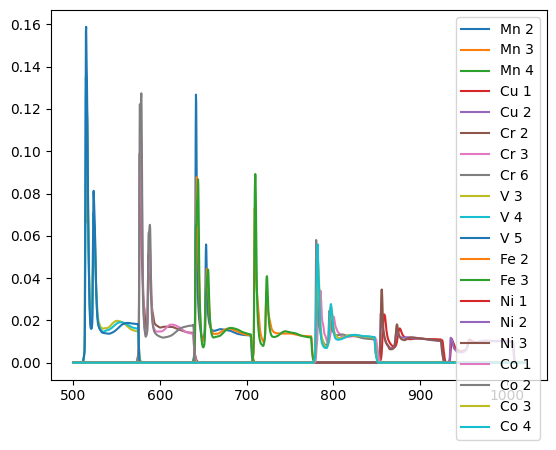

In [6]:
for element, value in data_use.items():
    for oxi, spectrum in value.items():
        plt.plot(np.arange(500, 1020, 0.3), spectrum, label=f"{element} {oxi}")

plt.legend()

In [7]:
def generate_mixed_oxidation_state(data, number_mixed_valance):
    '''
    Generate mixed oxidation state, return a dir with mixed valance.
    '''
    data_use = {}
    for element, value in data.items():

        oxidations_list = []
        spectra_list = []

        for oxi, spectrum in value.items():
            oxidations_list.append(oxi)
            spectra_list.append(spectrum)

        oxidations_list = np.array(oxidations_list)
        spectra_list = np.array(spectra_list)
            
        data_use[element] = {}

        for i in range(number_mixed_valance):

            weights = np.random.dirichlet(np.ones(len(oxidations_list)), size=1)[0]

            oxi_target_range = np.arange(0, 8)
            expanded_weights = np.zeros(len(oxi_target_range))

            for i, oxi in enumerate(oxidations_list):
                expanded_weights[oxi_target_range == oxi] = weights[i]
            oxi = np.sum(oxidations_list * weights)
            spectrum = np.sum(spectra_list * weights[:, np.newaxis], axis=0)
            data_use[element][oxi] = {}
            data_use[element][oxi]['spectrum'] = spectrum
            data_use[element][oxi]['weights'] = expanded_weights
            
    return data_use



In [8]:
data_mixed = generate_mixed_oxidation_state(data_use, 5000)




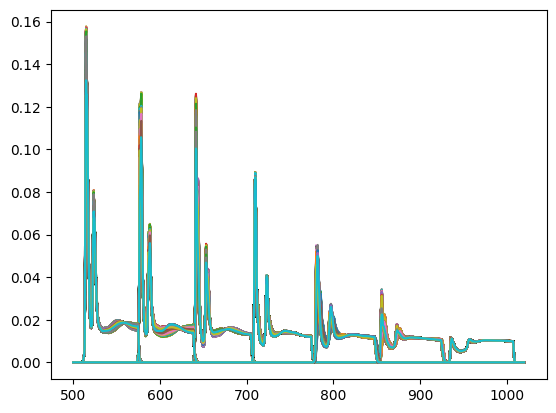

In [9]:
for element, value in data_mixed.items():
    for oxi, spectrum in value.items():
        plt.plot(np.arange(500, 1020, 0.3), spectrum['spectrum'], label=f"{element} {oxi}")

In [11]:
intensity_list = []
oxidation_list = []

for element, value in data_mixed.items():
    for oxi, spectrum in value.items():
        intensity_list.append(spectrum['spectrum'])
        oxidation_list.append(spectrum['weights'])

intensity_list = np.array(intensity_list)
oxidation_list = np.array(oxidation_list)


X = intensity_list
Y = oxidation_list

X.shape, Y.shape

np.save('../../jian_use/mp_mix_jian_mix_dataset/mixedX.npy', X)
np.save('../../jian_use/mp_mix_jian_mix_dataset/mixedY.npy', Y)

In [80]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42) # if you use same random state, same sets will be created
# 80-20% train test split

print("training size: ", x_train.shape, y_train.shape)
print("testing size: ", x_test.shape, y_test.shape)

training size:  (31500, 1734) (31500, 8)
testing size:  (3500, 1734) (3500, 8)


In [81]:
# save the data into numpy files

np.save("../dataset/mix_x_train.npy", x_train)
np.save("../dataset/mix_y_train.npy", y_train)
np.save("../dataset/mix_x_test.npy", x_test)
np.save("../dataset/mix_y_test.npy", y_test)


#can be loaded like so
x_train = np.load("../dataset/mix_x_train.npy")
x_train.shape

(31500, 1734)

Using non Mn Cu for training, and Mn Cu for testing.

In [17]:
intensity_list_training = []
oxidation_list_training = []
intensity_list_testing = []
oxidation_list_testing = []

for element, value in data_mixed.items():
    for oxi, spectrum in value.items():
        if element in ['Cu', 'V']:
            intensity_list_testing.append(spectrum['spectrum'])
            oxidation_list_testing.append(spectrum['weights'])
        else:
            intensity_list_training.append(spectrum['spectrum'])
            oxidation_list_training.append(spectrum['weights'])

# intensity_list_testing = np.array(intensity_list_testing)
# oxidation_list_testing = np.array(oxidation_list_testing)

# X = intensity_list_testing
# Y = oxidation_list_testing

# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42) # if you use same random state, same sets will be created

x_train = np.array(intensity_list_training)
y_train = np.array(oxidation_list_training)
x_test = np.array(intensity_list_testing)
y_test = np.array(oxidation_list_testing)


np.save("../../jian_use/V_Cu_x_train", x_train)
np.save("../../jian_use/V_Cu_y_train", y_train)
np.save("../../jian_use/V_Cu_x_test", x_test)
np.save("../../jian_use/V_Cu_y_test", y_test)


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000, 1734), (25000, 8), (10000, 1734), (10000, 8))

## Add Data from Other Sources

## Add Data from Experimental Reports (if available)

## Integer 60% + all integer_mixed for training, integer 40% + mp_mixed for testing

In [4]:
def remove_element_data(data):
	count = 0
	total = 0
	none_data = []
	for element, value in data.items():
		for mpid, spectrum in value.items():
			total += 1
			if spectrum['oxidation_state'] is None:
				count += 1
				none_data.append((element, mpid))

	for i in none_data:
		del data[i[0]][i[1]]

	return data

def get_interger_and_mixed(data):
	'''
	Get the integer oxidation states for each element.
	'''
	integer = 0
	mixed = 0
	integer_dir = {}
	mixed_dir = {}
	for element, value in data.items():
		integer_dir[element] = {}
		mixed_dir[element] = {}
		for mpid, spectrum in value.items():
			oxidation_state = spectrum['oxidation_state']
			if all_same_integers(oxidation_state): 
				integer_dir[element][mpid] = spectrum
				integer += 1
			else:
				mixed_dir[element][mpid] = spectrum
				mixed += 1

	print(f"Integer: {integer}, Mixed: {mixed}")

	return integer_dir, mixed_dir



In [5]:
with open('data_Mn-Cu-Cr-V-Fe-Ni-Co.pickle', 'rb') as f:
    data = pickle.load(f)

integer_dir, mixed_dir = get_interger_and_mixed(remove_element_data(data))

Integer: 5318, Mixed: 530


In [6]:
print(mixed_dir.keys())
print(mixed_dir['V'].keys())
print(mixed_dir['V']['mp-1201392'].keys())

dict_keys(['Mn', 'Cu', 'Cr', 'V', 'Fe', 'Ni', 'Co'])
dict_keys(['mp-1201392', 'mp-1194640', 'mp-27769', 'mp-1189345', 'mp-1188856', 'mp-610232', 'mp-32531', 'mp-18891', 'mp-19652', 'mp-19088', 'mp-638002', 'mp-19458', 'mp-1197031', 'mp-565732', 'mp-647265', 'mp-557916', 'mp-1201666', 'mp-600369', 'mp-1080573', 'mp-1197450', 'mp-565587', 'mp-1198376', 'mp-1195122', 'mp-540690', 'mp-617180', 'mp-1188322', 'mp-29211', 'mp-1202464', 'mp-579278', 'mp-1194238', 'mp-1197782', 'mp-1192478', 'mp-1195972', 'mp-566199', 'mp-19596', 'mp-567083', 'mp-27889', 'mp-554189', 'mp-1199049', 'mp-1205445', 'mp-650816', 'mp-1188787', 'mp-542050', 'mp-1198472', 'mp-32521', 'mp-19408', 'mp-795607', 'mp-1205274', 'mp-1198637', 'mp-567072', 'mp-783905', 'mp-642750', 'mp-17210', 'mp-619836', 'mp-676058', 'mp-696867', 'mp-554166', 'mp-19664', 'mp-715664', 'mp-619128', 'mp-19457', 'mp-25790', 'mp-541457', 'mp-510519', 'mp-504533', 'mp-683863', 'mp-870306', 'mp-622497', 'mp-18801', 'mp-18896', 'mp-622640', 'mp-5657

In [7]:
def full_intensity_oxidation_vector(data, energy_grid):
    '''
    return a dir with full smoothed intensity and oxidation vector.
    '''
    data_use = {}
    for element, value in data.items():
        data_use[element] = {}
        for mpid, spectrum in value.items():
            intensity = np.array(spectrum['intensity'])
            energy = np.array(spectrum['energy'])

            oxidation_list = np.array(spectrum['oxidation_state'])

            oxi_count = Counter(oxidation_list)
            oxi_vector = np.zeros(8)

            for index, count in oxi_count.items():
                oxi_vector[index] = count / sum(oxi_count.values())

            intensity_smoothed = savgol_smooth(intensity, energy, energy_grid, 1.5)
            data_use[element][mpid] = {}
            data_use[element][mpid]['intensity_vector'] = intensity_smoothed
            data_use[element][mpid]['oxidation_vector'] = oxi_vector

            
    return data_use

In [13]:
integer_dir = full_intensity_oxidation_vector(integer_dir, np.arange(500, 1020, 0.3))

In [14]:
intensity_vec = []
oxidation_vec = []


for element, value in integer_dir.items():
    for mpid, spectrum in value.items():
        intensity_vec.append(spectrum['intensity_vector'])
        oxidation_vec.append(spectrum['oxidation_vector'])

intensity_vec = np.array(intensity_vec)
oxidation_vec = np.array(oxidation_vec)

np.save("../../jian_use/mp_mix_jian_mix_dataset/mp_integer_intensity", intensity_vec)
np.save("../../jian_use/mp_mix_jian_mix_dataset/mp_integer_oxidation", oxidation_vec)